<a href="https://colab.research.google.com/github/HyeonhoonLee/OSAM_NLP/blob/master/BERT_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. EDA

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np 
import pandas as pd
import sklearn 
from sklearn import model_selection
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [16]:
# randsom seed
seed=1234
np.random.seed(seed)

In [17]:
num_classes=26

In [18]:
DATA_IN_PATH = '/content/drive/My Drive/DataCollection/OSAM/'

In [19]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file :
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
combined.csv                  6.62MB
combined_dup(-2000).csv       4.55MB
combined_clean(-2300).csv     4.51MB
combined_clean(6000)_sam.csv  4.02MB


In [20]:
#loading csv data
all_data = pd.read_csv(DATA_IN_PATH + 'combined_clean(6000)_sam.csv', quoting = 2)
all_data.head()

,symptom,class
0,질문하겠습니다. 이어폰을 음량을 0으로 하고 끼고만 있어도 귀에 안 좋나요?,ENT
1,독감예방주사,IP
2,목에 음식물 그대로 끼어서 계속 이물감이 있습니다,ENT
3,케겔운동 궁금한것,REHM
4,등 통증 관련문의,NS


In [21]:
# all_data의 전체 길이
len(all_data)

70749

In [22]:
# # To finding mislabelling with errata
# what = all_data.drop_duplicates("class", keep="first")
# what

In [23]:
# gotya = all_data[all_data["class"]=="UR"]
# gotya

In [24]:
#stratififed split to train_data, test_data
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_idx, test_idx in split.split(all_data, all_data["class"]):
    train_data = all_data.loc[train_idx]
    test_data = all_data.loc[test_idx]

In [25]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))
print('전체 학습데이터의 개수: {}'.format(len(test_data)))

전체 학습데이터의 개수: 56599
전체 학습데이터의 개수: 14150


In [26]:
train_length = train_data['symptom'].astype(str).apply(len)

In [27]:
train_length.head()

8157     34
45775    19
52697    10
66368    19
20021    13
Name: symptom, dtype: int64

Text(0, 0.5, 'Number of symptom')

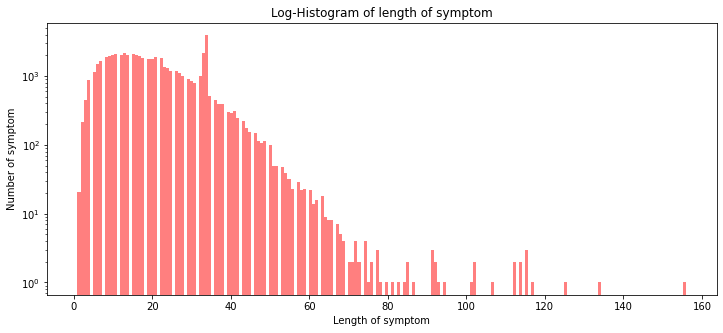

In [28]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of symptom')
# 그래프 x 축 라벨
plt.xlabel('Length of symptom')
# 그래프 y 축 라벨
plt.ylabel('Number of symptom')

In [29]:
print('증상 길이 최대 값: {}'.format(np.max(train_length)))
print('증상 길이 최소 값: {}'.format(np.min(train_length)))
print('증상 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('증상 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('증상 길이 중간 값: {}'.format(np.median(train_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('증상 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('증상 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

증상 길이 최대 값: 156
증상 길이 최소 값: 1
증상 길이 평균 값: 20.37
증상 길이 표준편차: 11.04
증상 길이 중간 값: 19.0
증상 길이 제 1 사분위: 12.0
증상 길이 제 3 사분위: 28.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f40e6eaea58>],
 'caps': [<matplotlib.lines.Line2D at 0x7f40e6e8e4a8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f40e6e982b0>],
 'means': [<matplotlib.lines.Line2D at 0x7f40e6e8ef28>],
 'medians': [<matplotlib.lines.Line2D at 0x7f40e6e8eba8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f40e6eaed68>,
  <matplotlib.lines.Line2D at 0x7f40e6e8e128>]}

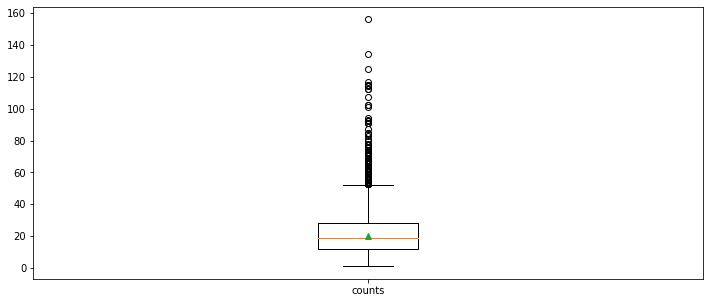

In [30]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(train_length,
             labels=['counts'],
             showmeans=True)

In [31]:
# 보통은 문자열이 아닌 데이터는 삭제하나, 증상의 경우 발열, 체중 등과 같은 내용이 중요하므로 숫자도 살려둔다.
# train_review = [review for review in train_data['document'] if type(review) is str]
train_symptom = [symptom for symptom in train_data['symptom'] if type(symptom) is (str or int or float)]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


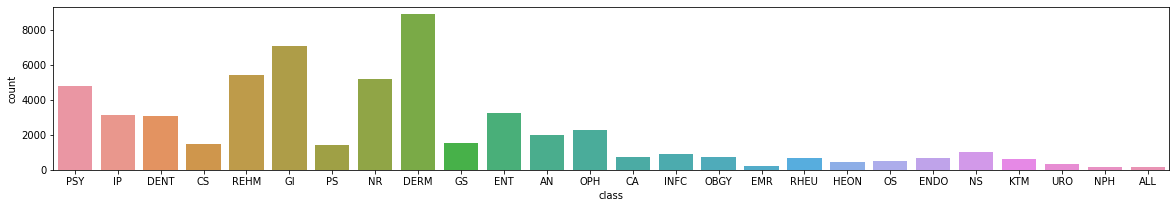

In [32]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(20, 3)
sns.countplot(train_data['class'])

In [33]:
# DERM: 피부과 / GS: 외과 / IP: 호흡기내과 / FM: 가정의학과 / GI: 소화기내과 / OPH: 안과
# NR: 신경과 / ENT: 이비인후과 / PSY : 신경정신과 / HEON: 혈액종양내과 / RHEU: 류마티스내과
# REHM: 재활의학과 / NS: 신경외과 / AN: 마취통증의학과 / DENT: 치과 / PS: 성형외과
# RAD: 영상의학과 / CS: 흉부외과 / INFC: 감염내과 / RAON: 방사선종양학과 / OS: 정형외과 
# EMR: 응급의학과 / ENDO: 내분비내과 / CA: 순환기내과 / KTM: 한방과 / OBGY: 산부인과
# URO: 비뇨기과 / ALL: 알레르기 내과 / NPH: 신장내과 / OEM:직업환경의학과 / COAN: 대장항문외과
# LAB: 진단검사의학과 

In [34]:
# convert class from string to integer
class_to_label = {'DERM': 0, 'GS': 1, 'IP': 2, 'GI':3, 'OPH':4,
                  'NR': 5, 'ENT': 6, 'PSY': 7, 'HEON': 8, 'RHEU': 9,
                  'REHM': 10, 'NS': 11, 'AN': 12, 'DENT': 13, 'PS': 14,
                  'CS': 15, 'INFC': 16, 'OS': 17,
                  'EMR': 18, 'ENDO': 19, 'CA': 20, 'KTM': 21, 'OBGY': 23,
                  'URO': 23, 'ALL': 24, 'NPH': 25}

train_data['label'] = train_data['class'].map(class_to_label)
test_data['label'] = test_data['class'].map(class_to_label)
train_data.head()

,symptom,class,label
8157,밤에 잠을 못드는 때가 있는데 그 때마다 금방이라도 죽 ...,PSY,7
45775,한달넘게 이유 없이 코물이 나와요.,IP,2
52697,치아 고민이에요..,DENT,13
66368,부정맥이 재발할 가능성이 있을까요?,CS,15
20021,무릎이 붓고 소리가 나요,REHM,10


In [35]:
# severe imbalenced data가 확인되지만 real-world로 반영한다고 생각하고 그대로 진행한다.
# 단, FM(가정의학과)의 비중이 너무 높고 오히려 OS 비중이 낮은 것은 본 프로젝트가 군인 대상인 점을 감안하여 조정이 필요할 것 같다.
for i in range(num_classes):
  print("증상 개수: {}".format(train_data['class'].value_counts()[i]))

증상 개수: 8870
증상 개수: 7045
증상 개수: 5402
증상 개수: 5167
증상 개수: 4814
증상 개수: 3262
증상 개수: 3118
증상 개수: 3084
증상 개수: 2253
증상 개수: 2014
증상 개수: 1549
증상 개수: 1474
증상 개수: 1404
증상 개수: 998
증상 개수: 928
증상 개수: 725
증상 개수: 708
증상 개수: 686
증상 개수: 671
증상 개수: 623
증상 개수: 507
증상 개수: 444
증상 개수: 315
증상 개수: 230
증상 개수: 162
증상 개수: 146


In [36]:
# 각 증상 서술의 단어 수를 확인.
# 데이터를 띄어쓰기 기준으로 나눠서 그 개수를 하나의 변수로 할당한다.
train_word_counts = train_data['symptom'].astype(str).apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Number of symptom')

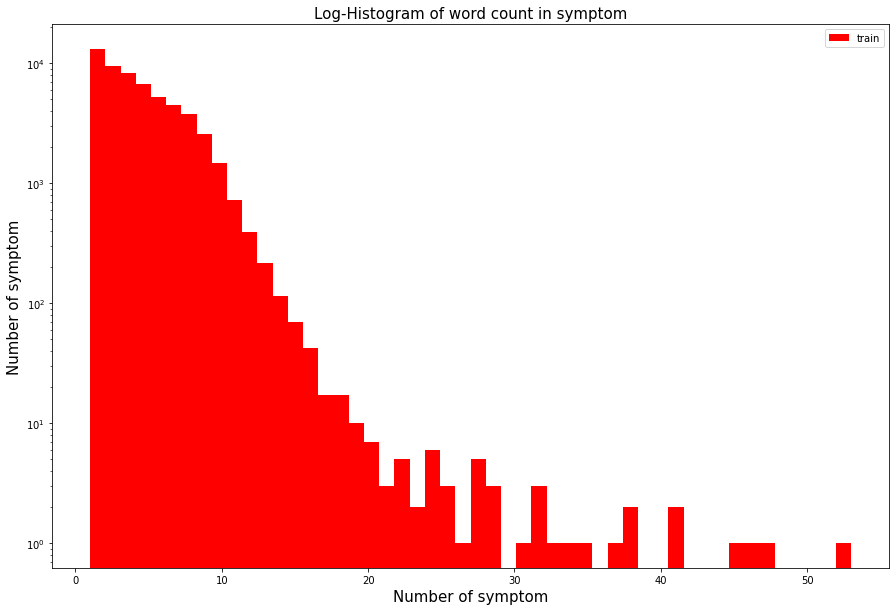

In [37]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in symptom', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of symptom', fontsize=15)
plt.ylabel('Number of symptom', fontsize=15)

In [38]:
print('증상 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('증상 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('증상 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('증상 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('증상 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('증상 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('증상 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

증상 단어 개수 최대 값: 53
증상 단어 개수 최소 값: 1
증상 단어 개수 평균 값: 4.72
증상 단어 개수 표준편차: 2.80
증상 단어 개수 중간 값: 4.0
증상 단어 개수 제 1 사분위: 3.0
증상 단어 개수 제 3 사분위: 6.0


In [39]:
# 특수문자 확인하기
qmarks = np.mean(train_data['symptom'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['symptom'].astype(str).apply(lambda x: '.' in x)) # 마침표
                  
print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))

물음표가있는 질문: 19.16%
마침표가 있는 질문: 33.58%


## 2. BERT를 이용한 fine tuning

In [40]:
### To solve the error(AttributeError: 'tuple' object has no attribute 'shape' error) while fitting model in Colab
## If using general IDE, latest version(2.3.0) of tensorflow might work.

# !pip install tensorflow==2.1.0
!pip install tensorflow==2.3.0

In [41]:
# installing transforemrs
!pip install transformers

     |████████████████████████████████| 1.1MB 4.4MB/s 
     |████████████████████████████████| 3.0MB 22.7MB/s 
     |████████████████████████████████| 890kB 29.9MB/s 
     |████████████████████████████████| 1.1MB 54.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=5b163620a0796067041b32a34ddd03791b3f5ec22879d4cbc9e0e656185645e4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [42]:
import re
from tqdm import tqdm

import tensorflow as tf 
from transformers import *

In [43]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [44]:
#random seed 고정
tf.random.set_seed(seed)

BATCH_SIZE = 32
NUM_EPOCHS = 3
# VALID_SPLIT = 0.2   ##이미 validation split을 straitified하게 시행함.
MAX_LEN = 40 # EDA상 3사분위 수가 word수가 7이었다. token 갯수는 대략 40으로 가정해본다.
# DATA_IN_PATH = 'data_in/KOR' ## EDA 
DATA_OUT_PATH = "/content/drive/My Drive/DataCollection/OSAM"

In [45]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

### 토크나이저 테스트

In [46]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [47]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# 토크나이저 테스트하기
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다. ")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


### Symptom to Specialty Classification (SSC)

In [48]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer(sent, MAX_LEN, truncation=True):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.  
        pad_to_max_length = True,
        return_attention_mask = True,
        truncation = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [49]:
# train_data 

input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["symptom"], train_data["label"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

## check... convert 'movie' to 'symptom'
train_symptom_input_ids = np.array(input_ids, dtype=int)
train_symptom_attention_masks = np.array(attention_masks, dtype=int)
train_symptom_type_ids = np.array(token_type_ids, dtype=int)
train_symptom_inputs = (train_symptom_input_ids, train_symptom_attention_masks, train_symptom_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_symptom_input_ids), len(train_data_labels)))

  0%|          | 0/56599 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 56599/56599 [00:11<00:00, 5049.09it/s]


# sents: 56599, # labels: 56599


In [50]:
# test_data
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["symptom"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_symptom_input_ids = np.array(input_ids, dtype=int)
test_symptom_attention_masks = np.array(attention_masks, dtype=int)
test_symptom_type_ids = np.array(token_type_ids, dtype=int)
test_symptom_inputs = (test_symptom_input_ids, test_symptom_attention_masks, test_symptom_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_symptom_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1773: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
14150it [00:02, 5205.85it/s]

num sents, labels 14150, 14150


In [51]:
# 최대 길이: 40
input_id = train_symptom_input_ids[1]
attention_mask = train_symptom_attention_masks[1]
token_type_id = train_symptom_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101   9954  89851 118732  14153   9638  42815  73610   9812  29364
  10739   8982  12638  48549    119    102      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[CLS] 한달넘게 이유 없이 코물이 나와요. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [52]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=num_classes)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], experimental_run_tf_function=False)

In [ ]:
model_name = "tf2_bert_symptom2class"



# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_symptom_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(test_symptom_inputs, test_data_labels),
                    validation_steps=(len(test_data_labels)/BATCH_SIZE)) 
                    # callbacks=[cp_callback, earlystop_callback]) ## CANNOT USE in transformers of TF 2.3

#steps_for_epoch

print(history.history)

/content/drive/My Drive/DataCollection/OSAM/tf2_bert_symptom2class -- Folder already exists 

Epoch 1/3
1769/1769 [==============================] - 590s 333ms/step - loss: 1.6460 - accuracy: 0.5411 - val_loss: 1.2976 - val_accuracy: 0.6297
Epoch 2/3
 321/1769 [====>.........................] - ETA: 7:25 - loss: 1.2402 - accuracy: 0.6446

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
# HOW TO SAVE?!?!
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'my_BERT_model.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cls_model.save_weights(checkpoint_path)    


## Testing for new sentences

In [ ]:
## To load a best weights from a saved file (.h5)  ====> for tf 2.1
# cls_model.load_weights(checkpoint_path)

## To load a model file )  ====> for tf 2.3
#new_model = tf.keras.models.load_model('my_model.h5')

In [ ]:
# exchanging key and value
label_to_class = {v:k for k,v in class_to_label.items()} 
label_to_class

In [ ]:
def specialty_predict(new_sentence):
  input_id, attention_mask, token_type_id = bert_tokenizer(new_sentence, MAX_LEN)

  new_symptom_input_id = np.array(input_id, dtype=int)
  new_symptom_attention_mask = np.array(attention_mask, dtype=int)
  new_symptom_type_id = np.array(token_type_id, dtype=int)
  new_symptom_input = (new_symptom_input_id, new_symptom_attention_mask, new_symptom_type_id)

  y_prob = cls_model.predict(new_symptom_input)
  y_label = y_prob.argmax(axis=-1)
  # w_count= {}
  # for lb in y_label:
  #     try: w_count[lb]+= 1
  #     except: w_count[lb]=1
  # print(w_count)
  # y_label_ans = y_label.argmax(axis=-1)
  # y_class = label_to_class.get(y_label[0])
  # loss, acc_score = cls_model.evaluate(new_symptom_input)
  
  # if(acc_score > 0.5):
  #   print("{:.2f}% 확률로 {}과를 방문하셔야합니다.\n".format(acc_score * 100, y_class))
  # else:
  #   print("증상을 좀 더 자세히 적어주세요.")
  print(y_prob)
  print(y_prob.shape)


In [ ]:
input_sentence = "얼마전부터 목이 뻐근하고 오른쪽 승모근이 아프더니 최근"
specialty_predict(input_sentence)

In [ ]:
 # keras 2.1의 predict나 evaluate에 문제가 있거나..아니면 데이터 부족의 문제인듯.
# 아무리 심한 Overfit이라고해도 acc 0.00은...